<a href="https://colab.research.google.com/github/ibonetc/Data_Analytics/blob/main/AWS/IA_FaceRecog_AWS_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Crear configuración de API

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Primero hay que crear un fichero con la configuración de las claves de uusario de AWS.
Crear un usuario en el servicio IAM y crear un fichero .txt con esta estructura:

[default]

aws_access_key_id=

aws_secret_access_key=

[texto del enlace](https://docs.aws.amazon.com/cli/latest/userguide/cli-configure-files.html)

Copiemos el fichero en una carpeta en nuestro Drive, activemos el drive y comencemos:

Para esto, en la primera página, cuando entramos a la cuenta,

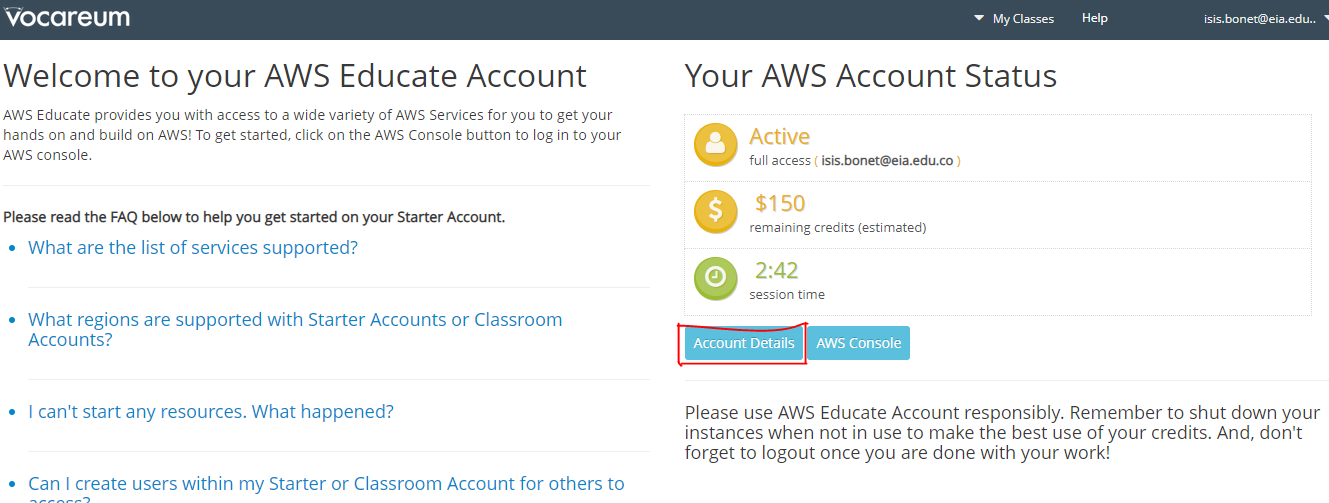

Ir a: **Account Details** y después a: **Show**
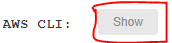


Y copia todo el texto en un .txt

In [ ]:
!mkdir -p ~/.aws &&\
  cp /content/drive/My\ Drive/AWS/credencials.txt ~/.aws/credentials

Probar API con un ejemplo sencillo de análisis de sentimientos en una frase.
Para esto usaremos el servicio de Comprehend de AWS

In [ ]:
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import boto3
comprehend = boto3.client(service_name='comprehend', region_name="us-east-2")
text = "Este curso es una maravilla"
comprehend.detect_sentiment(Text=text, LanguageCode='es')

{'Sentiment': 'POSITIVE',
 'SentimentScore': {'Positive': 0.9990971088409424,
  'Negative': 8.721462654648349e-05,
  'Neutral': 0.000726354424841702,
  'Mixed': 8.935611549532041e-05},
 'ResponseMetadata': {'RequestId': '52b45201-930e-40df-acc5-814fbd4f793e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '52b45201-930e-40df-acc5-814fbd4f793e',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '164',
   'date': 'Wed, 31 Aug 2022 22:38:07 GMT'},
  'RetryAttempts': 0}}

## Análisis de imágenes

Vamos a utilizar el servicio Rekognition

In [ ]:
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
G_Path='/content/drive/MyDrive/Fotos_Pruebas'
cisnes=G_Path+'/cisnes.jpg'
face=G_Path+'/face.jpg'
fiesta=G_Path+'/fiesta.jpg'
london=G_Path+'/london.jpg'
nottinghan=G_Path+'/Nottingham.jpg'
cisneNegro=G_Path+'/cisneNegro.jpg'
warwich=G_Path+'/warwick.jpg'
image_text=G_Path+'/text.jpg'
grupoI=G_Path+'/grupoI.jpg'
castilloMedellin=G_Path+'/CastilloMedellin.jpg'
cuba=G_Path+'/habana.jpg'

Se debe llamar al servicio ***rekognition***

In [ ]:
client = boto3.client(service_name='rekognition', region_name="us-east-2")

Hacer una función para leer la imagen en formato binario

In [ ]:
def openImage(file_image):
  with open(file_image, 'rb') as openfile:
    content = openfile.read()
  return content

### Detección de rostro

Para esto hay que tener en cuenta los datos que me dan.

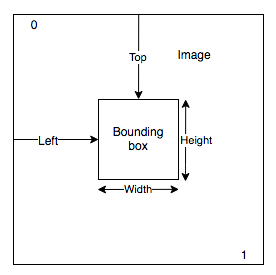

In [ ]:
file_image='/content/tejada.jpg'

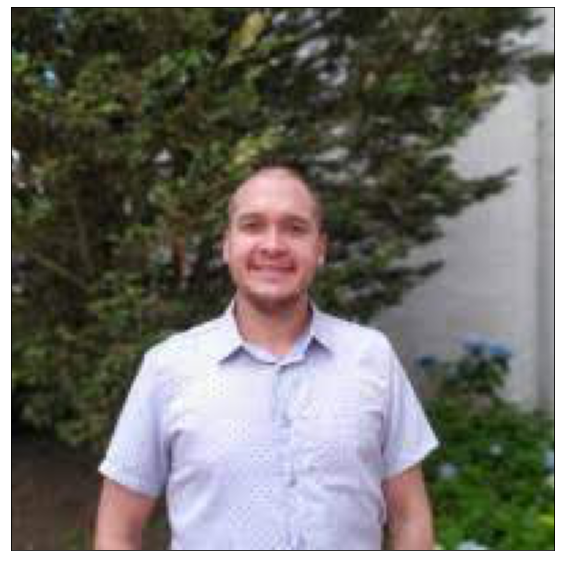

In [ ]:
#file_image=castilloMedellin
img = plt.imread(file_image)
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(img)

In [ ]:
image=openImage(file_image)
response = client.detect_faces(Image={'Bytes': image}, Attributes=["ALL"])

In [ ]:
for faceDetail in response['FaceDetails']:
  print('La edad está entre ' + str(faceDetail['AgeRange']['Low']) + ' y ' + str(faceDetail['AgeRange']['High']) + ' años')

La edad está entre 25 y 39 años


In [ ]:
img.shape

(2988, 5312, 3)

In [ ]:
img = plt.imread(file_image)
#img=cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
imgWidth = img.shape[1]
imgHeight = img.shape[0]
box=response['FaceDetails'][0]['BoundingBox']
left = int(imgWidth * box['Left'])
top = int(imgHeight * box['Top'])
width = int(imgWidth * box['Width'])
height = int(imgHeight * box['Height'])
img=cv2.rectangle(img,(left,top),(left+width,top+height),(0,255,0),2)

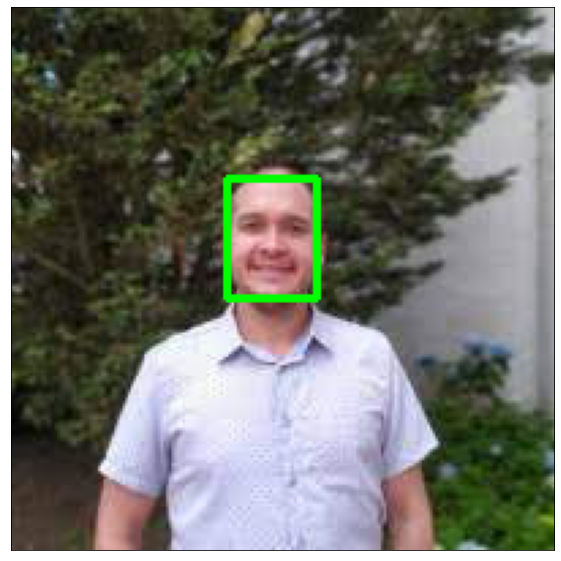

In [ ]:
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(img)

### Imágenes rotadas
¿Qué pasa si la imagen está rotada?

AWS en sus procesos rota las imágenes si ellas están rotadas

La biblioteca ***piexif*** me ayuda a saber si la imagen está rotada

`piexif.load(face)["0th"][piexif.ImageIFD.Orientation]` tendrá un número

*   3: 180º
*   6: 90º
*   8: 270º
*   1: 0º


In [ ]:
!pip install piexif

In [ ]:
import piexif

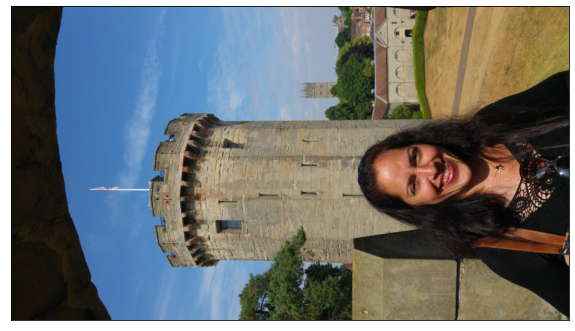

In [ ]:
file_image=face
img = plt.imread(file_image)

plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(img)

In [ ]:
exif_dict = piexif.load(face)
exif_dict["0th"][piexif.ImageIFD.Orientation]

6

In [ ]:
exif_dict = piexif.load(castilloMedellin)
exif_dict["0th"][piexif.ImageIFD.Orientation]

1

Función para rotar la imagen si tiene el parámetro de rotación

In [ ]:
def rotate(filename):
  exif_dict = piexif.load(filename)
  img = plt.imread(filename)
  if piexif.ImageIFD.Orientation in exif_dict["0th"]:
      orientation = exif_dict["0th"][piexif.ImageIFD.Orientation]
      if orientation == 3:# 180 grados
          return cv2.rotate(img, cv2.ROTATE_180)
      elif orientation == 6: # 90 grados
          return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
      elif orientation == 8:#270
          return cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
      else:
          return img
  else:
      return img

Función para trazar un rectángulo en la zona detectada. Se le pasa la imagen y el box que contiene las coordenadas.

Esta nos puede servir para dibujar el rectángulo dada las coordenadas de detección de rostro o de objetos.

In [ ]:
def rectFace(img,box):
  imgWidth = img.shape[1]
  imgHeight = img.shape[0]
  left = int(imgWidth * box['Left'])
  top = int(imgHeight * box['Top'])
  width = int(imgWidth * box['Width'])
  height = int(imgHeight * box['Height'])
  img_rotate=cv2.rectangle(img,(left,top),(left+width,top+height),(255,0,0),12)
  return img, [left, top, left+width, top+height]

Función para detectar rostros. Todos los rostros que sean detectados

In [ ]:
def detectface(client, filename):
  image=openImage(filename)
  response=client.detect_faces(Image={'Bytes': image}, Attributes=["ALL"])
  #img = plt.imread(filename)
  img = rotate(filename)
  faces=response['FaceDetails']
  for f in faces:
    box = f['BoundingBox']
    img,_=rectFace(img,box)
  return img, response

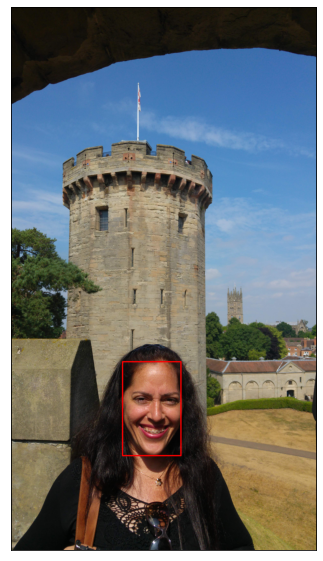

In [ ]:
plt.figure(figsize=(10,10))
img,response=detectface(client,face)
plt.xticks([])
plt.yticks([])
plt.imshow(img)

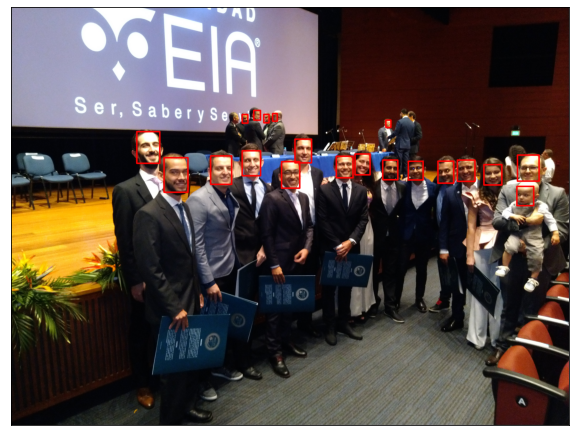

In [ ]:
plt.figure(figsize=(10,10))
img,_=detectface(client,grupoI)
plt.xticks([])
plt.yticks([])
plt.imshow(img)

## Comparación de rostros

La función ***compare_face*** permite comparar un rostro de una imagen pasada en el parámtro *SourceImage*, en otra imagen pasada como parámetro en *TargetImage*

In [ ]:
image1=openImage(face)
image2=openImage(grupoI)
response=client.compare_faces(TargetImage={'Bytes': image2}, SourceImage={'Bytes': image1})

In [ ]:
faces=response['FaceMatches']
box=response['FaceMatches'][0]['Face']['BoundingBox']
img = rotate(grupoI)
img,_=rectFace(img,box)

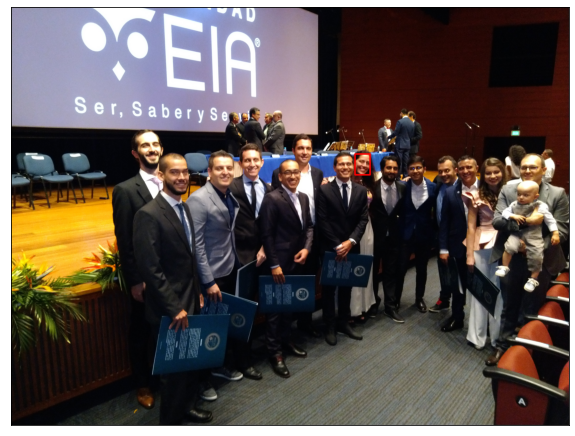

In [ ]:
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(img)

Función para encontrar el rostro de la imagen *SourceImage*

In [ ]:
def compareFaces(fileSource, fileTarget):
  image1=openImage(fileSource)
  image2=openImage(fileTarget)
  response=client.compare_faces(TargetImage={'Bytes': image2}, SourceImage={'Bytes': image1})
  faces=response['FaceMatches']
  box=response['FaceMatches'][0]['Face']['BoundingBox']
  image1=rotate(fileSource)
  img = rotate(fileTarget)
  img,_=rectFace(img,box)
  return image1,img

([], <a list of 0 Text major ticklabel objects>)

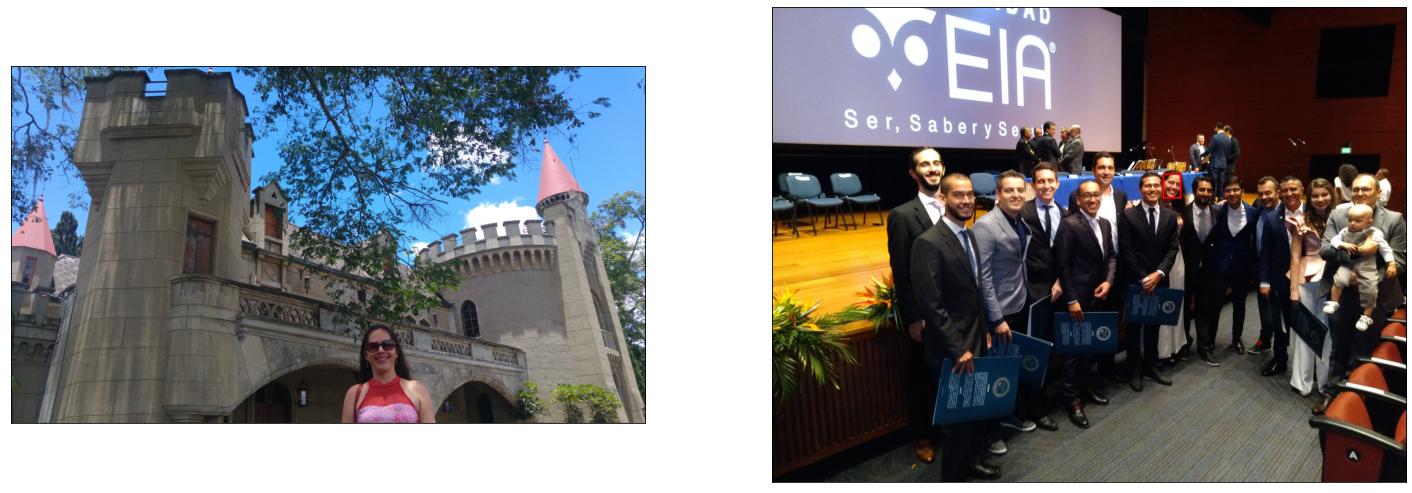

In [ ]:
from matplotlib import gridspec
img1,img2=compareFaces(castilloMedellin, grupoI)
plt.figure(figsize=(25,25))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.xticks([])
plt.yticks([])

Si las imágenes están degradadas o difusas, se puede bajar el porciento de similaridad con el parámetro: SimilarityThreshold

## Detección de objetos

In [ ]:
image=openImage(cuba)
response = client.detect_labels(Image={'Bytes': image})

In [ ]:
labels=[(e['Name'], e['Confidence']) for e in response['Labels']]
for e in labels:
  print(e)

('Shorts', 99.88737487792969)
('Clothing', 99.88737487792969)
('Apparel', 99.88737487792969)
('Person', 98.02891540527344)
('Human', 98.02891540527344)
('Sunglasses', 93.4618148803711)
('Accessories', 93.4618148803711)
('Accessory', 93.4618148803711)
('Road', 90.81436920166016)
('Car', 90.4419174194336)
('Automobile', 90.4419174194336)
('Vehicle', 90.4419174194336)
('Transportation', 90.4419174194336)
('Metropolis', 89.895263671875)
('Urban', 89.895263671875)
('City', 89.895263671875)
('Building', 89.895263671875)
('Town', 89.895263671875)
('Tarmac', 89.75242614746094)
('Asphalt', 89.75242614746094)
('Sleeve', 84.14701843261719)
('Wheel', 75.34337615966797)
('Machine', 75.34337615966797)
('Intersection', 72.71649169921875)
('Architecture', 58.74534606933594)
('Long Sleeve', 55.39900588989258)
('Parking Lot', 55.345428466796875)
('Parking', 55.345428466796875)


In [ ]:
def detectobjects(filename):
  image=openImage(filename)
  response = client.detect_labels(Image={'Bytes': image}) # MaxLabels=10
  img=rotate(filename)
  for l in response['Labels']:
    name=l['Name']
    for i in l['Instances']:
      box=i['BoundingBox']
      img,v=rectFace(img,box)
      img=cv2.putText(img, name, (v[0],v[1]), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4, cv2.LINE_AA)
  return img

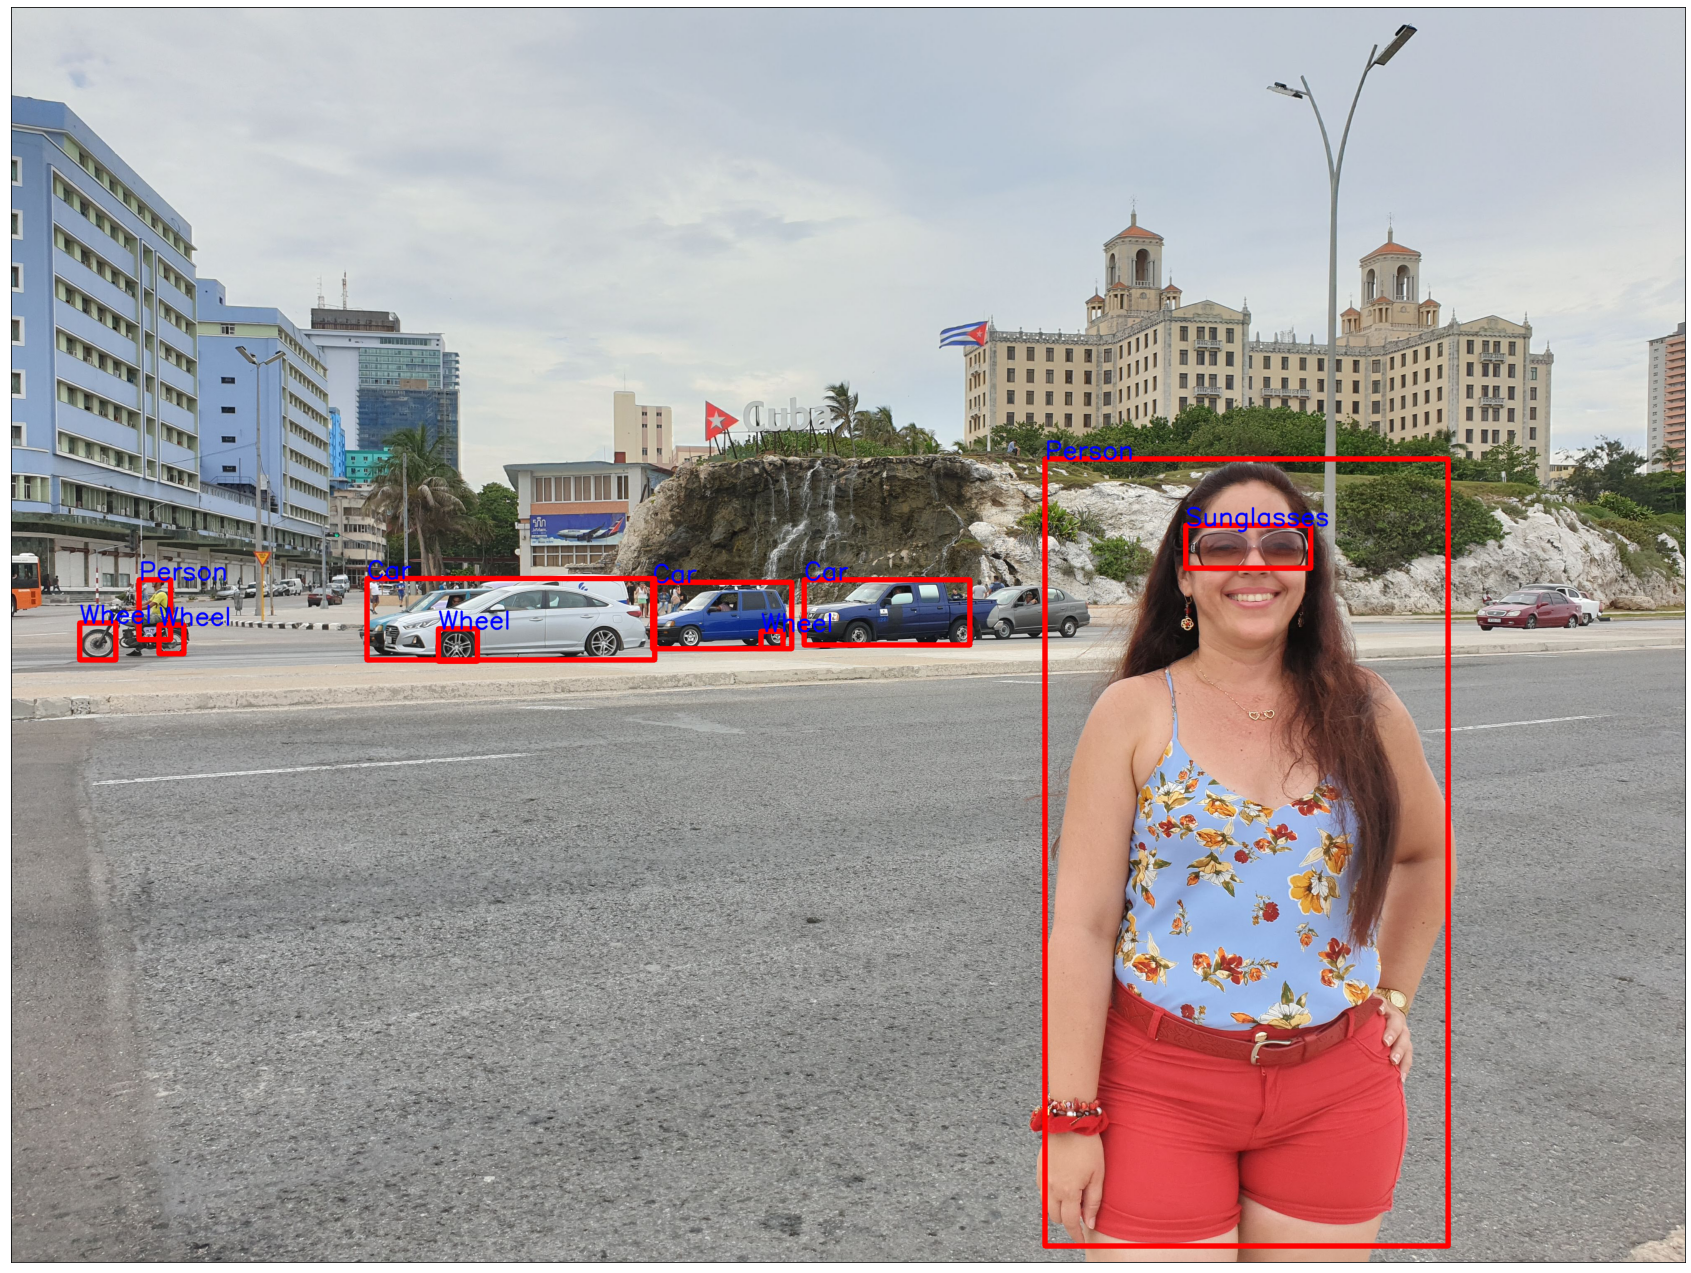

In [ ]:
img=detectobjects(cuba)
plt.figure(figsize=(30,30))
plt.xticks([])
plt.yticks([])
plt.imshow(img)

## Detección de texto

In [ ]:
image=openImage(image_text)
response = client.detect_text(Image={'Bytes': image})

In [ ]:
def detectText(filename):
  image=openImage(filename)
  response = client.detect_text(Image={'Bytes': image})
  img=rotate(filename)
  detection=response['TextDetections']
  texts=[t['DetectedText'] for t in detection]
  for i,t in enumerate(detection):
    text=t['DetectedText']
    box=t['Geometry']['BoundingBox']
    img,v=rectFace(img,box)
    img=cv2.putText(img, str(i), (v[0],v[1]), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4, cv2.LINE_AA)
  return img,texts

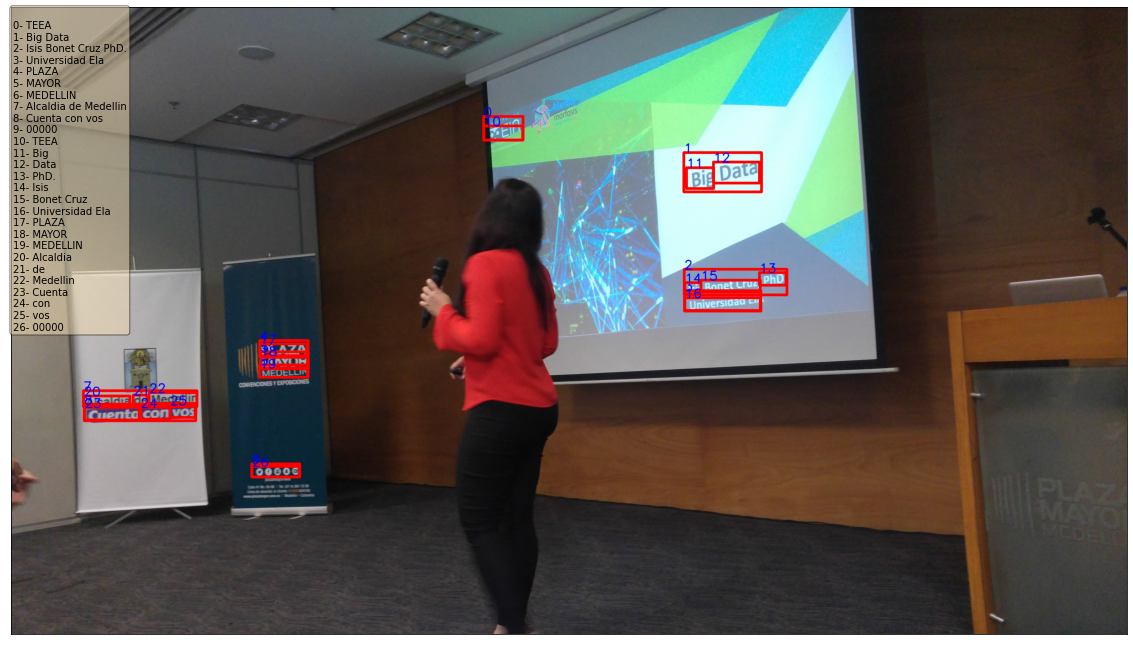

In [ ]:
img,texts=detectText(image_text)
t=''
for i,e in enumerate(texts):
  t = t+'\n'+str(i)+'- '+ e
plt.figure(figsize=(20,20))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(10, 10, t, fontsize=10,verticalalignment='top', bbox=props)
plt.xticks([])
plt.yticks([])
plt.imshow(img)